# Data Mining Project - Week 2 - Cuisine Clustering and Map Construction

## Data Mining Specialization - Coursera / University of Illinois at Urbana-Champaign

* Author: Michael Onishi
* Date: November, 2019

### Description
The goal of this task is to mine the data set to construct a cuisine map to visually understand the landscape of different types of cuisines and their similarities. The cuisine map can help users understand what cuisines are available and their relations, which allows for the discovery of new cuisines, thus facilitating exploration of unfamiliar cuisines.




### Dataset setup

In [1]:
! wget https://d396qusza40orc.cloudfront.net/dataminingcapstone/YelpDataset/yelp_dataset.tar.gz
! tar xzf yelp_dataset.tar.gz

--2019-11-13 14:49:16--  https://d396qusza40orc.cloudfront.net/dataminingcapstone/YelpDataset/yelp_dataset.tar.gz
Resolving d396qusza40orc.cloudfront.net (d396qusza40orc.cloudfront.net)... 13.226.52.230, 13.226.52.117, 13.226.52.107, ...
Connecting to d396qusza40orc.cloudfront.net (d396qusza40orc.cloudfront.net)|13.226.52.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443445047 (423M) [application/x-gzip]
Saving to: ‘yelp_dataset.tar.gz’

yelp_dataset.tar.gz 100%[===================>] 422.90M  61.3MB/s    in 7.1s    

2019-11-13 14:49:24 (59.7 MB/s) - ‘yelp_dataset.tar.gz’ saved [443445047/443445047]



In [2]:
! pip install unidecode -q

     |████████████████████████████████| 245kB 2.8MB/s 


In [0]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import re
from joblib import dump, load
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering

# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns
sns.set(style="whitegrid")


from itertools import chain
from collections import Counter

In [0]:
path2files="yelp_dataset_challenge_academic_dataset/"
path2business=path2files+"yelp_academic_dataset_business.json"
path2reviews=path2files+"yelp_academic_dataset_review.json"

df_bus = pd.read_json(path2business, lines=True).set_index('business_id')
df_reviews = pd.read_json(path2reviews, lines = True).set_index('review_id')

Filtering only Restaurants

In [0]:
df_bus = df_bus[df_bus.categories.apply(lambda x : 'Restaurants' in x)]

In [6]:
df_bus.categories.apply(lambda x : x.remove('Restaurants'))

business_id
JwUE5GmEO-sH1FuwJgKBlQ    None
uGykseHzyS5xAMWoN6YUqA    None
LRKJF43s9-3jG9Lgx4zODg    None
RgDg-k9S5YD_BaxMckifkg    None
rdAdANPNOcvUtoFgcaY9KA    None
                          ... 
ZpB2O-WAbbRHdP0V8GrwXA    None
OEUIE8VBa1BbBfr5EPcTOA    None
yZXEELxi8KMwzXCHP345GQ    None
uUsfpN81JCMKyH6c0D0bTg    None
BMjggIgOghBMEXPo8q7q3w    None
Name: categories, Length: 14303, dtype: object

In [0]:
df = df_reviews.merge(df_bus, on = 'business_id')

In [8]:
df.head()

,votes,user_id,stars_x,date,text,type_x,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars_y,latitude,attributes,type_y
0,"{'funny': 0, 'useful': 1, 'cool': 0}",zvNimI98mrmhgNOOrzOiGg,4,2008-07-07,Pretty good dinner with a nice selection of fo...,review,JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[],De Forest,26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
1,"{'funny': 0, 'useful': 0, 'cool': 0}",p4ySEi8PEli0auZGBsy6gA,4,2009-05-03,Good truck stop dining at the right price. We ...,review,JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[],De Forest,26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
2,"{'funny': 6, 'useful': 0, 'cool': 0}",ZYaumz29bl9qHpu-KVtMGA,4,2009-05-04,"If you like lot lizards, you'll love the Pine ...",review,JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[],De Forest,26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
3,"{'funny': 0, 'useful': 0, 'cool': 0}",SvS7NXWG2B2kFoaHaWdGfg,4,2010-10-30,Enjoyable experience for the whole family. The...,review,JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[],De Forest,26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
4,"{'funny': 0, 'useful': 0, 'cool': 0}",qOYI9O0ecMJ9VaqcM9phNw,4,2011-02-06,One of my favorite truck stop diners with soli...,review,JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[],De Forest,26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business


In [0]:
def preprocess(text):
    # Remove accents
    text = unidecode(text)
    # Remove line breaks and tab
    text = re.sub(r'[\t\n\r]', '', text)
    # Remove http links
    text = re.sub(r'http\S+', '', text)
    # Convert to lowercase
    text = text.lower().strip()
    return text

In [0]:
df.text = df.text.apply(lambda x : preprocess(x))

In [0]:
df_categories = pd.DataFrame.from_dict(Counter(chain(*df.categories)), orient='index').sort_values(0, ascending=False)[0]

# only considering categories with more than 5000 reviews
df_categories = df_categories[df_categories > 5000]

In [12]:
print(len(df_categories))
df_categories.head()

51


American (New)            94183
Nightlife                 87471
American (Traditional)    84895
Bars                      82511
Mexican                   70406
Name: 0, dtype: int64

In [13]:
df_categories.sum()

1347264

In [0]:
# joining all the text reviews for each of the categories
cat_dict = {cat : ' '.join(df[df.categories.apply(lambda x : cat in x)].text) for cat in df_categories.index}

In [0]:
df_categories_with_text = pd.DataFrame.from_dict(cat_dict, orient = 'index', columns = ['text'])

In [16]:
df_categories_with_text.head()

,text
American (New),may be one of middleton's best kept secrets......
Nightlife,what could i possibly say about the beach hous...
American (Traditional),a really lovely surprise on a rather horrific ...
Bars,what could i possibly say about the beach hous...
Mexican,great margaritas.but it's hard to review a mex...


### Task 2.1: Visualization of the Cuisine Map

Use all the reviews of restaurants of each cuisine to represent that cuisine and compute the similarity of cuisines based on the similarity of their corresponding text representations. Visualize the similarities of the cuisines and describe your visualization.

In [0]:
def vectorize(text_list, max_features=20000):
    print(f"Vectorizing {len(text_list)} documents using {max_features} max_features")
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=max_features,
                             min_df=2, stop_words='english',
                             use_idf=True,
                             token_pattern='[a-zA-Z0-9]{3,}')
    
    return vectorizer, vectorizer.fit_transform(text_list)

def create_lda_model(matrix, n_components = 10):
    print(f"Creating LDA model with {n_components} components")
    lda_model = LatentDirichletAllocation(n_components=n_components,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=42,          # Random state
                                      batch_size=512,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                         )
    lda_model.fit(matrix)
    return lda_model

In [18]:
%%time
vectorizer, matrix = vectorize(df_categories_with_text.text, max_features = 100000)

Vectorizing 51 documents using 100000 max_features
CPU times: user 1min 42s, sys: 1.34 s, total: 1min 44s
Wall time: 1min 44s


In [19]:
matrix

<51x100000 sparse matrix of type '<class 'numpy.float64'>'
	with 697428 stored elements in Compressed Sparse Row format>

In [0]:
pairwise_similarity = matrix * matrix.T

In [21]:
pairwise_similarity.shape

(51, 51)

In [22]:
pairwise_similarity.toarray()

array([[1.        , 0.35895341, 0.24879928, ..., 0.06421714, 0.03271775,
        0.02138583],
       [0.35895341, 1.        , 0.3264817 , ..., 0.05306302, 0.02593781,
        0.32364956],
       [0.24879928, 0.3264817 , 1.        , ..., 0.04638826, 0.06757157,
        0.02757962],
       ...,
       [0.06421714, 0.05306302, 0.04638826, ..., 1.        , 0.04269743,
        0.00196607],
       [0.03271775, 0.02593781, 0.06757157, ..., 0.04269743, 1.        ,
        0.00174446],
       [0.02138583, 0.32364956, 0.02757962, ..., 0.00196607, 0.00174446,
        1.        ]])

In [0]:
def plot_similarity_matrix(matrix, labels):  
  fig, ax = plt.subplots(figsize=(20,20))
  cax = ax.matshow(matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
  ax.grid(True)
  plt.xticks(range(len(labels)), labels, rotation=90);
  plt.yticks(range(len(labels)), labels);
  #fig.colorbar(cax)
  plt.show()

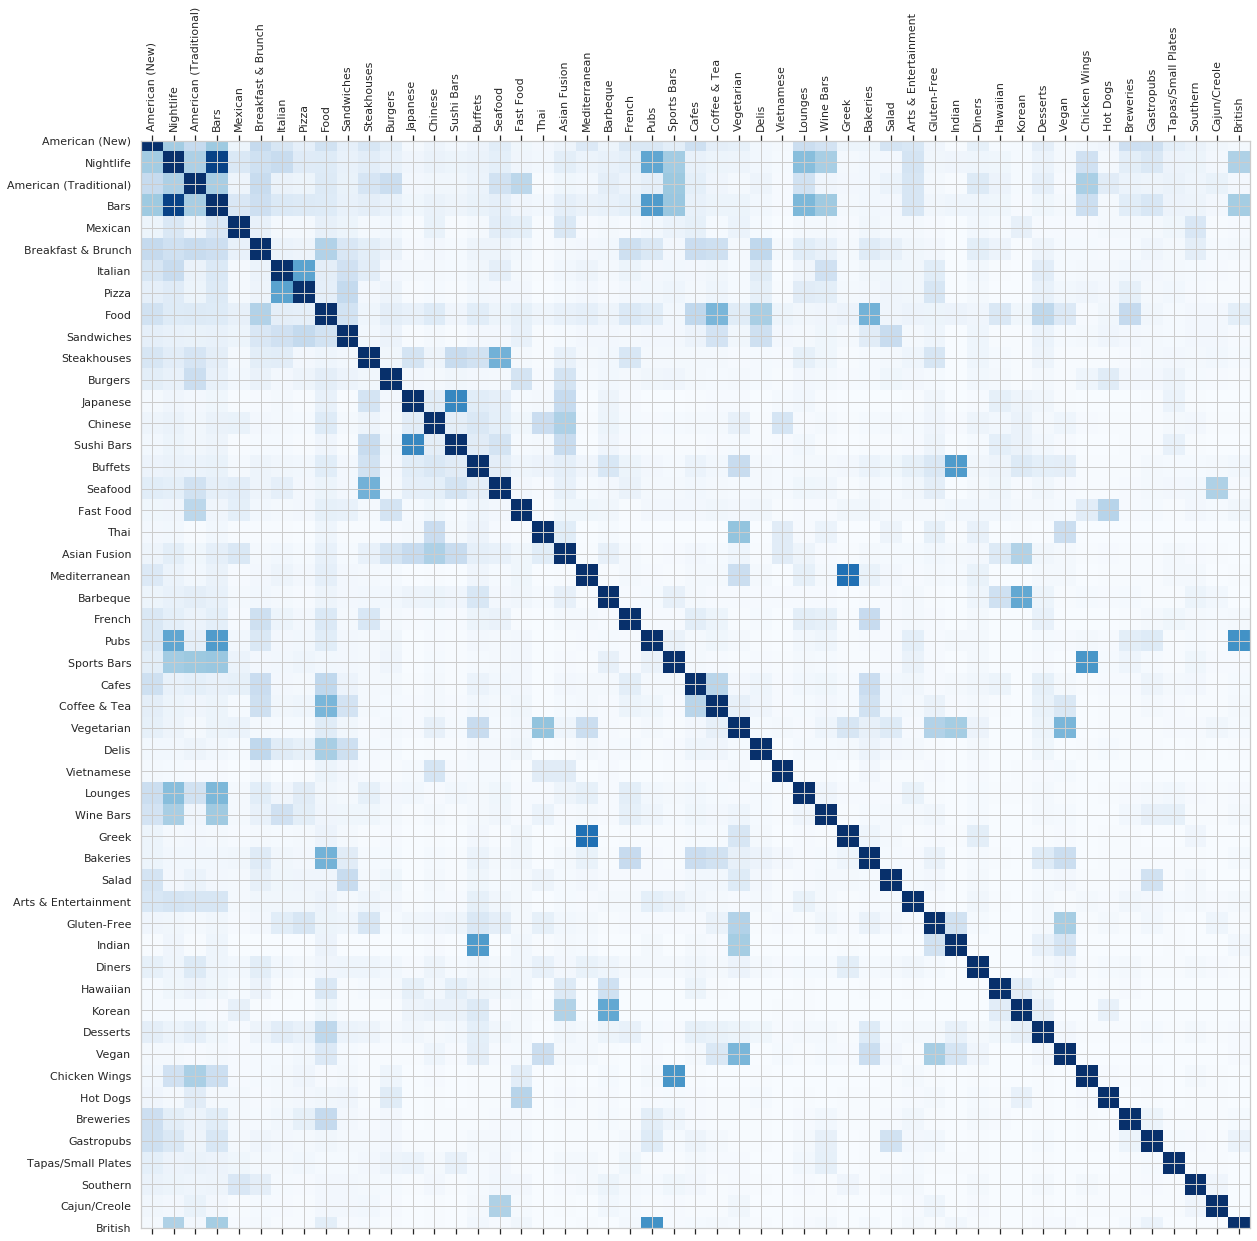

In [24]:
labels = list(df_categories_with_text.index)
plot_similarity_matrix(pairwise_similarity.toarray(), labels)

In [124]:
%%time
lda_model = create_lda_model(matrix, n_components = 50)

Creating LDA model with 50 components
CPU times: user 8.84 s, sys: 3.43 s, total: 12.3 s
Wall time: 1min 10s


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/online_lda.py:780: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)


In [0]:
lda_matrix = lda_model.transform(matrix)

In [126]:
lda_matrix.shape

(51, 50)

In [0]:
lda_pairwise_similarity = (lda_matrix @ lda_matrix.T)

In [133]:
lda_pairwise_similarity

array([[3.89937234e-01, 3.13575513e-01, 5.29709763e-04, ...,
        5.13005661e-01, 2.12589678e-01, 3.24488101e-02],
       [3.13575513e-01, 5.68447347e-01, 5.28507505e-04, ...,
        2.80565771e-01, 6.54398460e-01, 9.71705316e-02],
       [5.29709763e-04, 5.28507505e-04, 7.63017244e-01, ...,
        1.18545160e-03, 1.45349195e-03, 1.53551852e-03],
       ...,
       [5.13005661e-01, 2.80565771e-01, 1.18545160e-03, ...,
        9.11829040e-01, 2.05870100e-03, 2.13805089e-03],
       [2.12589678e-01, 6.54398460e-01, 1.45349195e-03, ...,
        2.05870100e-03, 8.86599268e-01, 1.31935681e-01],
       [3.24488101e-02, 9.71705316e-02, 1.53551852e-03, ...,
        2.13805089e-03, 1.31935681e-01, 6.58965070e-01]])

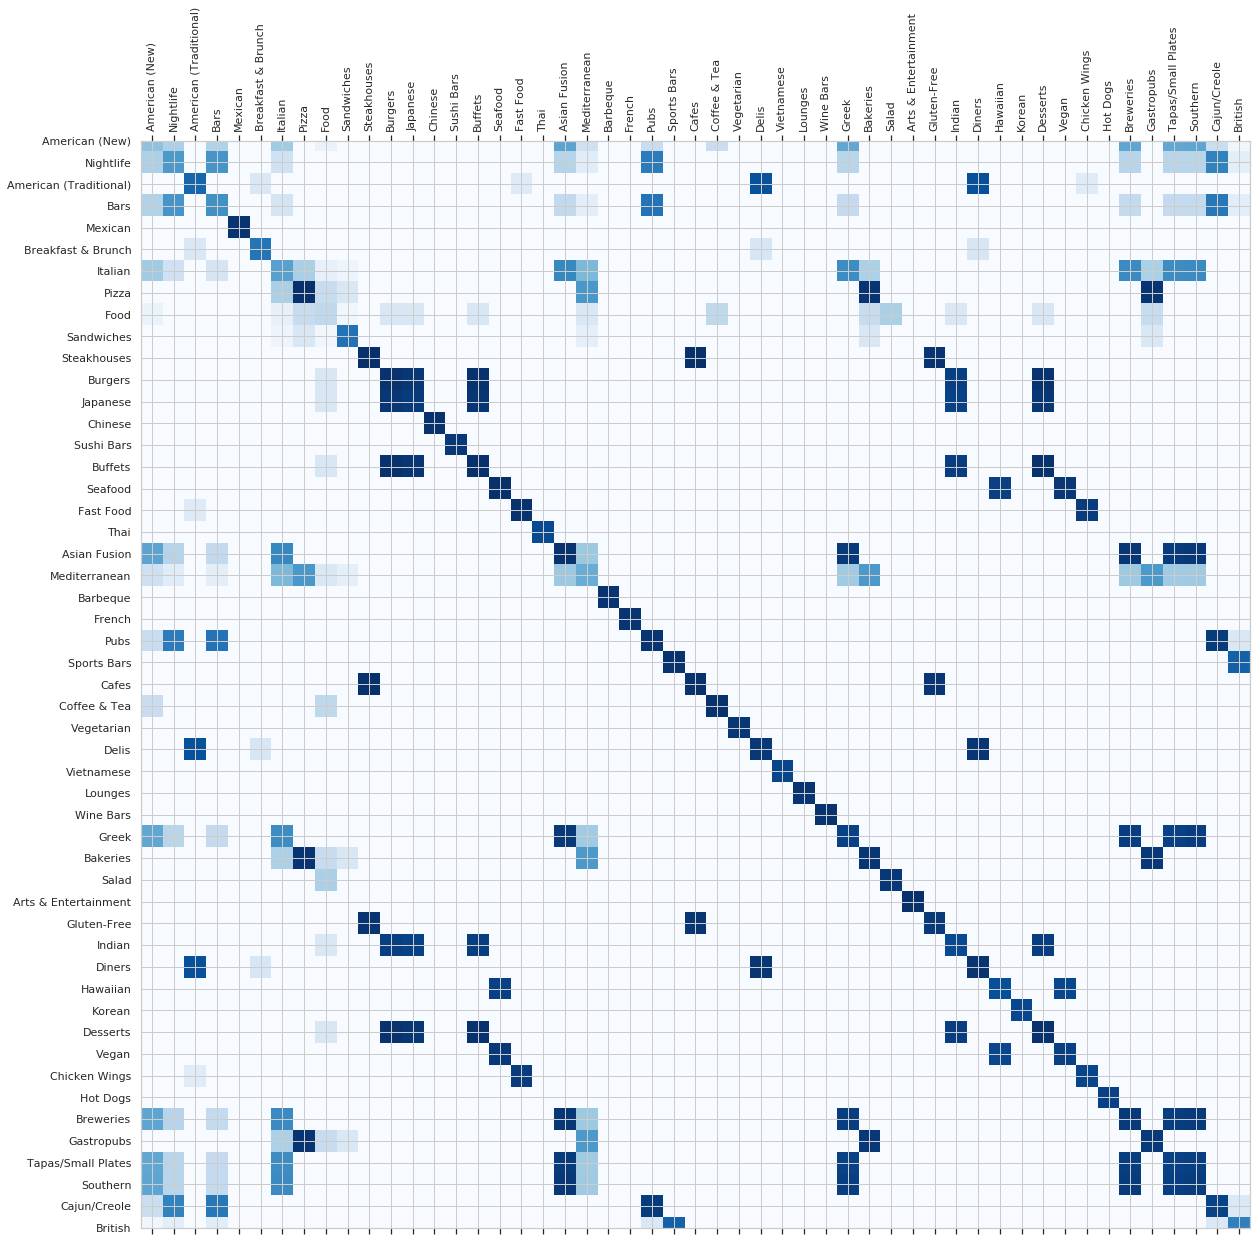

In [134]:
plot_similarity_matrix(lda_pairwise_similarity, labels)

In [0]:
topk_idx = np.argsort(-lda_pairwise_similarity, axis=1)[:,:5]

In [136]:
lda_pairwise_similarity[0].argsort()[::-1][:4]

array([19, 45, 48, 32])

In [138]:
for i, indexes in enumerate(topk_idx):
  print(labels[i])
  for idx in indexes:
    if idx != i and lda_pairwise_similarity[i][idx] > 0.8:
      print('> %s\t%s' % (lda_pairwise_similarity[i][idx], labels[idx]))

American (New)
Nightlife
American (Traditional)
> 0.8386929060256921	Diners
> 0.8323011828365606	Delis
Bars
Mexican
Breakfast & Brunch
Italian
Pizza
> 0.9420202484462726	Bakeries
> 0.9357720054995421	Gastropubs
Food
Sandwiches
Steakhouses
> 0.9509423501460693	Cafes
> 0.9388990326240222	Gluten-Free
Burgers
> 0.9483644992150012	Buffets
> 0.9462406120482153	Desserts
> 0.9297770137528536	Japanese
> 0.901545979730575	Indian
Japanese
> 0.9332701538188987	Buffets
> 0.9311807990868443	Desserts
> 0.9297770137528536	Burgers
> 0.8872128600218302	Indian
Chinese
Sushi Bars
Buffets
> 0.9497969650268407	Desserts
> 0.9483644992150012	Burgers
> 0.9332701538188987	Japanese
> 0.9049307251520453	Indian
Seafood
> 0.9251610406314035	Vegan
> 0.8977564370981396	Hawaiian
Fast Food
> 0.9119463374417899	Chicken Wings
Thai
Asian Fusion
> 0.9305428743560596	Breweries
> 0.9273166916149236	Southern
> 0.9175364358614861	Greek
> 0.9165187195977821	Tapas/Small Plates
Mediterranean
Barbeque
French
Pubs
> 0.9131331970889

### Task 2.3: Incorporating Clustering in Cuisine Map

Use any similarity results from Task 2.1 or Task 2.2 to do clustering. Visualize the clustering results to show the major categories of cuisines. Vary the number of clusters to try at least two very different numbers of clusters, and discuss how this affects the quality or usefulness of the map. Use multiple clustering algorithms for this task.



In [0]:
def clusterize(n_clusters, X):
  model = KMeans(n_clusters=n_clusters, random_state=42, n_jobs=-1)
  clusters = model.fit_predict(X)
  return clusters, model

In [0]:
def find_optimal_clusters(X, min_k, max_k):
    iters = range(min_k, max_k+1, 2)
    
    sse = []
    for k in iters:
      print(f'Fitting {k} clusters')
      _, model = clusterize(n_clusters=k, X = X)
      sse.append(model.inertia_)
      
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

Fitting 2 clusters
Fitting 4 clusters
Fitting 6 clusters
Fitting 8 clusters
Fitting 10 clusters
Fitting 12 clusters
Fitting 14 clusters
Fitting 16 clusters
Fitting 18 clusters
Fitting 20 clusters
CPU times: user 1.98 s, sys: 2.78 s, total: 4.76 s
Wall time: 6min 6s


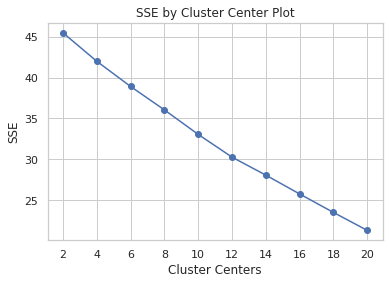

In [170]:
%%time
find_optimal_clusters(matrix, 2, 20)

Fitting 20 clusters
Fitting 22 clusters
Fitting 24 clusters
Fitting 26 clusters
Fitting 28 clusters
Fitting 30 clusters
Fitting 32 clusters
Fitting 34 clusters
Fitting 36 clusters
Fitting 38 clusters
Fitting 40 clusters
CPU times: user 4.14 s, sys: 4.68 s, total: 8.83 s
Wall time: 7min 49s


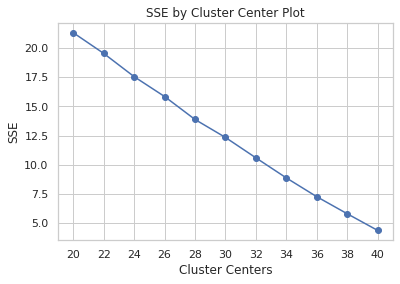

In [173]:
%%time
find_optimal_clusters(matrix, 20, 40)

Fitting 42 clusters
Fitting 44 clusters
Fitting 46 clusters
Fitting 48 clusters
Fitting 50 clusters
CPU times: user 2.53 s, sys: 2.57 s, total: 5.1 s
Wall time: 4min 2s


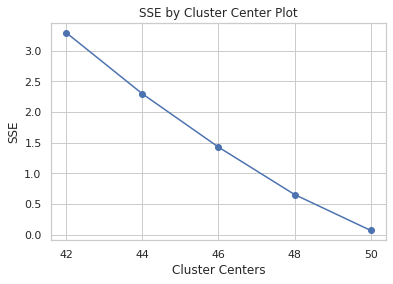

In [174]:
%%time
find_optimal_clusters(matrix, 42, 50)

In [0]:
%%time

# It's not clear what would be the best number of clusters. I will go with 10.
clusters, model = clusterize(n_clusters=10, X = matrix)

In [0]:
def show_clusters(clusters, labels):
  ret = [[] for i in range(clusters.max()+1)]
  for i, idx in enumerate(clusters):
    ret[idx].append(labels[i])
  
  for i, x in enumerate(ret):
    print(f'Cluster {i}')
    print(', '.join(x))
    print()

In [182]:
show_clusters(clusters, labels)

Cluster 0
Salad, Gastropubs

Cluster 1
Steakhouses, Japanese, Sushi Bars, Buffets, Indian

Cluster 2
Italian, Pizza, Sandwiches, Wine Bars

Cluster 3
Nightlife, Bars, Pubs, British

Cluster 4
American (New), American (Traditional), Burgers, Seafood, Fast Food, Sports Bars, Lounges, Arts & Entertainment, Diners, Chicken Wings, Hot Dogs, Tapas/Small Plates, Southern, Cajun/Creole

Cluster 5
Mexican, Breakfast & Brunch, Food, French, Cafes, Coffee & Tea, Delis, Bakeries, Hawaiian, Desserts, Breweries

Cluster 6
Mediterranean, Greek

Cluster 7
Barbeque, Korean

Cluster 8
Thai, Vegetarian, Gluten-Free, Vegan

Cluster 9
Chinese, Asian Fusion, Vietnamese



In [0]:
pca2d = PCA(n_components=2).fit_transform(matrix.todense())

In [0]:
centroids = model.cluster_centers_

In [0]:
def plot_scatter(X, Y, cluster_labels, point_labels):
  fig = plt.figure(figsize=(20, 20))

  colors = [plt.cm.hsv(i/cluster_labels.max()) for i in cluster_labels]

  plt.scatter(X, Y, c=colors, s=200)

  for x, y, label in zip(X, Y, point_labels):
      plt.annotate('{0}'.format(label), (x,y), rotation=15)

  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')

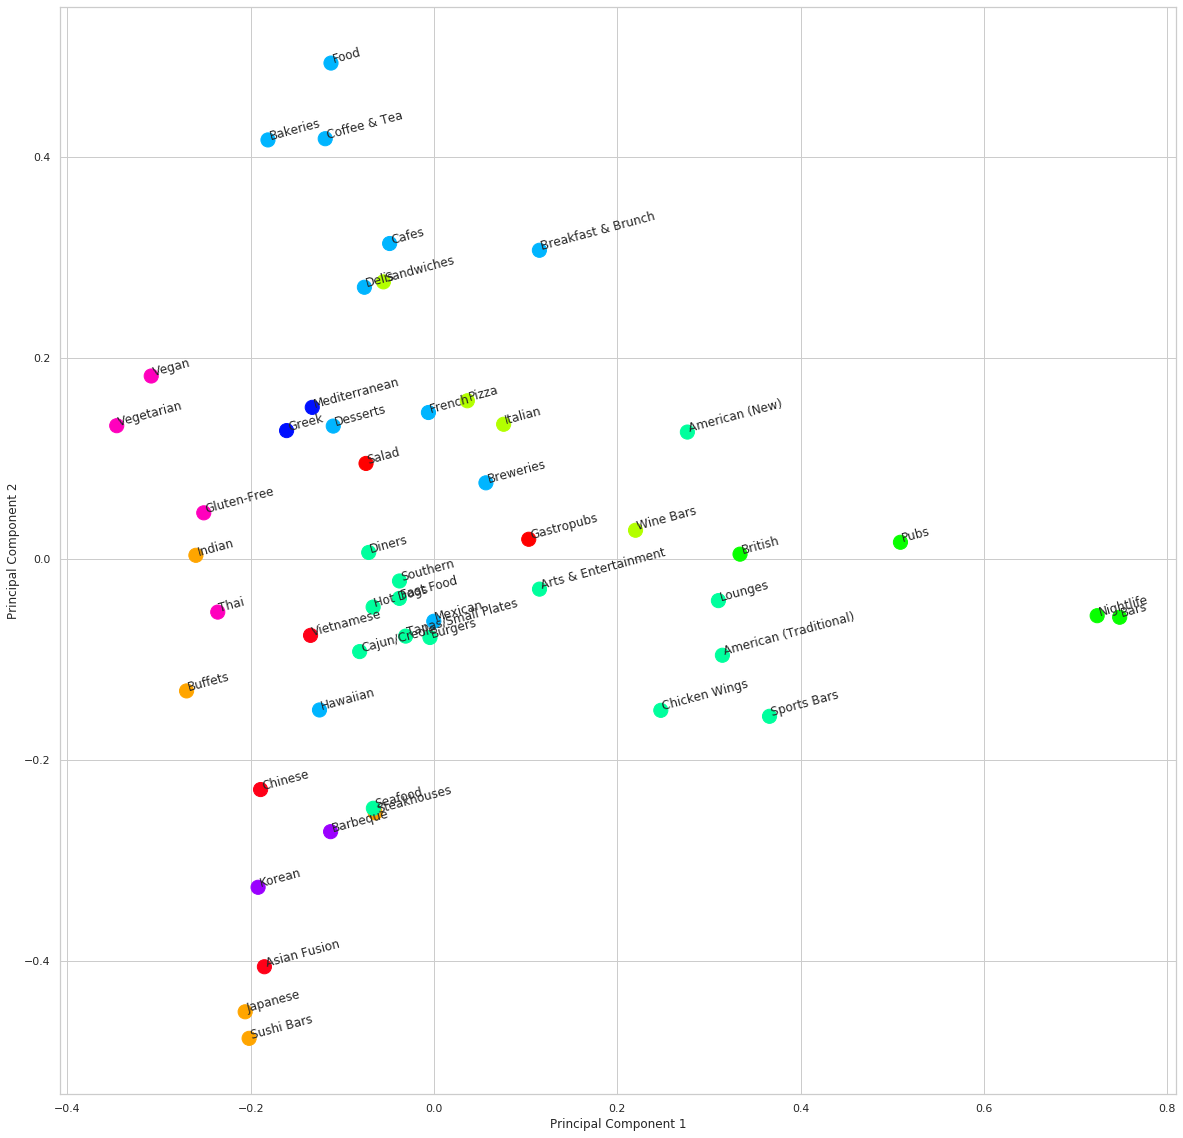

In [246]:
plot_scatter(X = pca2d[:,0], Y = pca2d[:,1], cluster_labels = model.labels_, point_labels=labels)

In [0]:
spectral_cluster = SpectralClustering(n_clusters=10, random_state=42).fit(matrix)

In [249]:
show_clusters(spectral_cluster.labels_, labels)

Cluster 0
Breakfast & Brunch, Food, French, Cafes, Coffee & Tea, Delis, Bakeries, Desserts

Cluster 1
American (New), Mexican, Sandwiches, Burgers, Chinese, Fast Food, Asian Fusion, Vietnamese, Lounges, Wine Bars, Salad, Arts & Entertainment, Diners, Hawaiian, Hot Dogs, Breweries, Gastropubs, Tapas/Small Plates, Southern

Cluster 2
Japanese, Sushi Bars

Cluster 3
Buffets, Thai, Vegetarian, Gluten-Free, Indian, Vegan

Cluster 4
American (Traditional), Sports Bars, Chicken Wings

Cluster 5
Italian, Pizza

Cluster 6
Mediterranean, Greek

Cluster 7
Barbeque, Korean

Cluster 8
Steakhouses, Seafood, Cajun/Creole

Cluster 9
Nightlife, Bars, Pubs, British



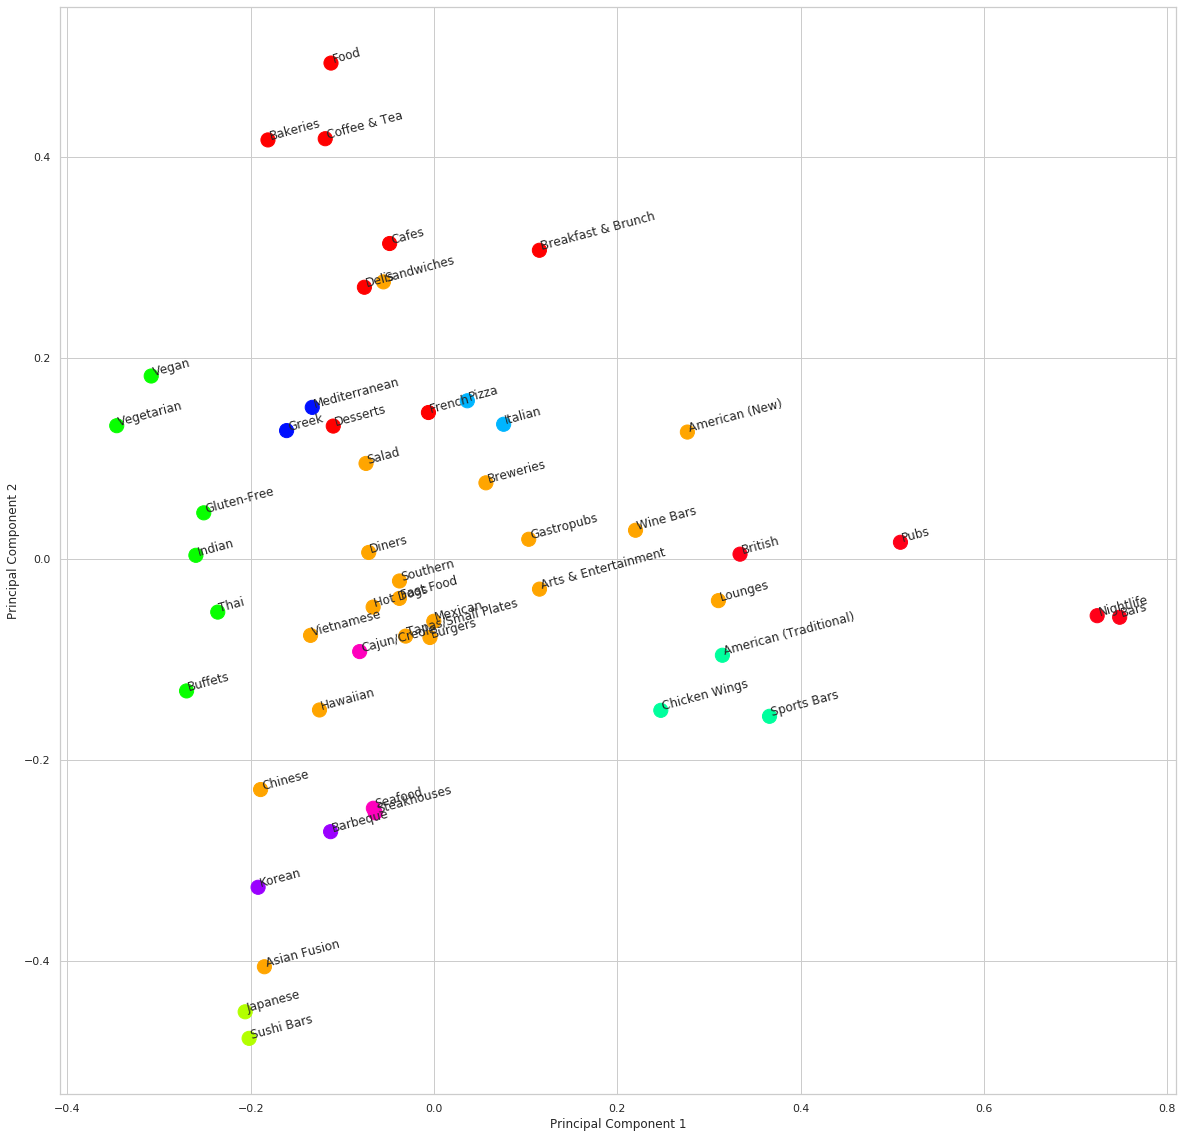

In [250]:
plot_scatter(X = pca2d[:,0], Y = pca2d[:,1], cluster_labels = spectral_cluster.labels_, point_labels=labels)